# 基于多模态的文本分类
## 一、模型介绍
### 1. Vision Transformer（ViT）
#### ViT模型简介
近些年，随着基于自注意（Self-Attention）结构的模型的发展，特别是Transformer模型的提出，极大地促进了自然语言处理模型的发展。由于Transformers的计算效率和可扩展性，它已经能够训练具有超过100B参数的空前规模的模型。

ViT则是自然语言处理和计算机视觉两个领域的融合结晶。在不依赖卷积操作的情况下，依然可以在图像分类任务上达到很好的效果。
#### ViT模型结构
ViT模型的主体结构是基于Transformer模型的Encoder部分（部分结构顺序有调整，如：Normalization的位置与标准Transformer不同），其结构图如下：
![image.png](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/vit_architecture.png)
#### 模型特点
+ 数据集的原图像被划分为多个patch后，将二维patch（不考虑channel）转换为一维向量，再加上类别向量与位置向量作为模型输入
+ 模型主体的Block结构是基于Transformer的Encoder结构，但是调整了Normalization的位置，其中，最主要的结构依然是Multi-head Attention结构
+ 模型在Blocks堆叠后接全连接层，接受类别向量的输出作为输入并用于分类。通常情况下，我们将最后的全连接层称为Head，Transformer Encoder部分为backbone

### 2. Transform Decorder
Transformer模型源于2017年的一篇文章。在这篇文章中提出的基于Attention机制的编码器-解码器型结构在自然语言处理领域获得了巨大的成功。进入transformer, 看到它是由encoding部分和decoding部分构成

![image.png](https://images.gitee.com/uploads/images/2022/0703/221242_83d9889a_11270550.png)

进一步拆解，每个encoding部分由一系列的encoder构成（paper中是6个，当然这个数字也可以调整），decoding部分由相同数量的decoder构成。
![image.png](https://images.gitee.com/uploads/images/2022/0703/221302_4a517157_11270550.png)

encoder们的结构是相同的（但是它们不共享参数），每个encoder又由两部分组成。
![image.png](https://images.gitee.com/uploads/images/2022/0703/221313_a80a10cd_11270550.png)

encoder的input先进入self attention层，在过一个单词时，这个self attention可以同时关注句子里的其他单词，该层的输出会进入到feed-forward网络，每个位置的单词都会有一个完全相同的feed-forward网络。

decorder也有encoder的两层，同时在两层之间还有一个attention层，帮助decoder聚焦在句子相关的部分上。
![image.png](https://images.gitee.com/uploads/images/2022/0703/221325_562758cd_11270550.png)

### 3. LSTM
#### LSTM模型简介
长短期记忆网络（Long-Short Term Memory,LSTM）论文首次发表于1997年。由于独特的设计结构，LSTM适合于处理和预测时间序列中间隔和延迟非常长的重要事件。
LSTM的表现通常比时间递归神经网络及隐马尔科夫模型（HMM）更好，比如用在不分段连续手写识别上。2009年，用LSTM构建的人工神经网络模型赢得过ICDAR手写识别比赛冠军。LSTM还普遍用于自主语音识别，2013年运用TIMIT自然演讲数据库达成17.7%错误率的纪录。作为非线性模型，LSTM可作为复杂的非线性单元用于构造更大型深度神经网络。
#### LSTM模型结构
LSTM是一种含有LSTM区块（blocks）或其他的一种类神经网络，文献或其他资料中LSTM区块可能被描述成智能网络单元，因为它可以记忆不定时间长度的数值，区块中有一个gate能够决定input是否重要到能被记住及能不能被输出output。
图1底下是四个S函数单元，最左边函数依情况可能成为区块的input，右边三个会经过gate决定input是否能传入区块，左边第二个为input gate，如果这里产出近似于零，将把这里的值挡住，不会进到下一层。左边第三个是forget gate，当这产生值近似于零，将把区块里记住的值忘掉。第四个也就是最右边的input为output gate，他可以决定在区块记忆中的input是否能输出 。
![image.png](https://images.gitee.com/uploads/images/2022/0703/221337_e18a4c76_11270550.png)
LSTM有很多个版本，其中一个重要的版本是GRU（Gated Recurrent Unit），根据谷歌的测试表明，LSTM中最重要的是Forget gate，其次是Input gate，最次是Output gate。

#### LSTM训练方法
为了最小化训练误差，梯度下降法（Gradient descent）如：应用时序性倒传递算法，可用来依据错误修改每次的权重。梯度下降法在递回神经网络（RNN）中主要的问题初次在1991年发现，就是误差梯度随着事件间的时间长度成指数般的消失。当设置了LSTM 区块时，误差也随着倒回计算，从output影响回input阶段的每一个gate，直到这个数值被过滤掉。因此正常的倒传递类神经是一个有效训练LSTM区块记住长时间数值的方法。

## 二、数据集

Fakeddit数据集:来自多个类别的假新闻的超过 100 万个样本组成。经过几个阶段的审查处理后，通过远程监督将样本按照2-way、3-way和6-way分类类别进行标记。数据来源：https://arxiv.org/abs/1911.03854 Fakeddit: A New Multimodal Benchmark Dataset for Fine-grained Fake News Detection。



### 数据集目录结构

### 数据预处理

将图像和文本数据以及对应的标签进行数据集划分，并构建单词词表。

In [ ]:
import json
from PIL import Image
import random
import os
import numpy as np

text0 = 'dataset/multimodel_data/text0.txt'
text1 = 'dataset/multimodel_data/text1.txt'
text5 = 'dataset/multimodel_data/text5.txt'

wordset=set()

data=[]

with open(text0,encoding='utf8') as f:
    for line in f:
        #print(line)
        line = line.strip()
        parts = line.split(' ')
        word = parts[:-2]
        img = parts[-2]
        label = parts[-1]
        #print(word,'dataset/multimodel_data/0/'+img,label)
        img_path = 'dataset/multimodel_data/0/'+img
        if not os.path.exists(img_path):
            continue
        image = Image.open(img_path)
        image = np.copy(image)
        if len(image.shape)!= 3 or image.shape[2]!=3 :
            continue

        words = ' '.join(word)
        data.append((words,'dataset/multimodel_data/0/'+img,label))
        wordset = wordset.union(set(word))

with open(text1,encoding='utf8') as f:
    for line in f:
        #print(line)
        line = line.strip()
        parts = line.split(' ')
        word = parts[:-2]
        img = parts[-2]
        label = parts[-1]

        img_path = 'dataset/multimodel_data/1/'+img
        if not os.path.exists(img_path):
            continue
        image = Image.open(img_path)
        image = np.copy(image)
        if len(image.shape)!= 3 or image.shape[2]!=3:
            continue

        #print(word,'dataset/multimodel_data/1/'+img,label)
        words = ' '.join(word)
        data.append((words, img_path, label))
        wordset = wordset.union(set(word))

with open(text5,encoding='utf8') as f:
    for line in f:
        #print(line)
        line = line.strip()
        parts = line.split(' ')
        word = parts[:-2]
        img = parts[-2]
        label = parts[-1]

        img_path = 'dataset/multimodel_data/5/' + img
        if not os.path.exists(img_path):
            continue
        image = Image.open(img_path)
        image = np.copy(image)

        if len(image.shape) != 3 or image.shape[2]!=3:
            continue

        #print(word,'dataset/multimodel_data/3/'+img,label)
        words = ' '.join(word)
        data.append((words, img_path, label))
        wordset = wordset.union(set(word))

print(len(wordset))

word2id={}
for i,word in enumerate(list(wordset)):
    word2id[word] = i+1
word2id['<pad>'] = 0

with open('dataset/word2id.json','w',encoding='utf8') as f:
    json.dump(word2id,f,ensure_ascii=False,indent=4)

random.shuffle(data)
print(len(data))

train_data = data[:int(len(data)*0.6)]
val_data = data[int(len(data)*0.6):int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]

print(len(train_data),len(val_data),len(test_data))

with open('dataset/train/train.txt','w',encoding='utf8') as f:
    for t in train_data:
        f.write(t[0]+'\t'+t[1]+'\t'+str(t[2])+'\n')


with open('dataset/val/val.txt','w',encoding='utf8') as f:
    for t in val_data:
        f.write(t[0]+'\t'+t[1]+'\t'+str(t[2])+'\n')

with open('dataset/test/test.txt','w',encoding='utf8') as f:
    for t in test_data:
        f.write(t[0]+'\t'+t[1]+'\t'+str(t[2])+'\n')

### 自定义dataset

In [ ]:
import mindspore.dataset as ds
import json
import numpy as np
from PIL import Image
def prepare_sequence(seqs, word_to_idx):
    seq_outputs, label_outputs, seq_length = [], [], []
    #print(seqs)
    max_len = max([len(i) for i in seqs])
    print(max_len)

    for seq in seqs:
        #print(seq)
        seq_length.append(len(seq))
        idxs = [word_to_idx[w] for w in seq]
        idxs.extend([word_to_idx['<pad>'] for i in range(max_len - len(seq))])
        #print('idsx',len(idxs),'seq_length',seq_length)
        seq_outputs.append(idxs)


    return np.array(seq_outputs, dtype=np.int64),np.array(seq_length, dtype=np.int64)

class MyDataset:
    """自定义数据集类"""

    def __init__(self,flag='train'):
        """自定义初始化操作"""
        # self.image,self.sentence,self.label = get_train_data()  # 自定义数据
        # print(self.image,self.sentence.self.label)
        with open('dataset/word2id.json') as f:

            word2id = json.load(f)

        sen_data = []
        img_list = []
        label = []

        if flag =='train':
            with open('dataset/train/train.txt') as f:
                for line in f:
                    line =line.strip()
                    parts = line.split('\t')
                    sen_data.append(parts[0].split(' '))
                    img_list.append(parts[1])
                    label.append(int(parts[2]))
        elif flag =='val':
            with open('dataset/val/val.txt') as f:
                for line in f:
                    line =line.strip()
                    parts = line.split('\t')
                    sen_data.append(parts[0].split(' '))
                    img_list.append(parts[1])
                    label.append(int(parts[2]))
        elif flag =='test':
            with open('dataset/test/test.txt') as f:
                for line in f:
                    line =line.strip()
                    parts = line.split('\t')
                    sen_data.append(parts[0].split(' '))
                    img_list.append(parts[1])
                    label.append(int(parts[2]))

        sen,length = prepare_sequence(sen_data,word2id)

        img = []
        for img_path in img_list:
            image = Image.open(img_path)
            image = image.resize((224, 224))
            x = np.copy(image)
            data = ((x - np.min(x)) / (np.max(x) - np.min(x))).astype(np.float32)
            #print(data.shape)
            data = data.swapaxes(0,2)
            data = data.swapaxes(1, 2)
            #print(data.shape)
            img.append(data.tolist())


        # x = np.random.randint(0, 255, [200, 3,224,224])
        # data = ((x - np.min(x)) / (np.max(x) - np.min(x))).astype(np.float32)
        #
        # y = ms.Tensor(shape=(200, 30, 32), dtype=ms.float32, init=Normal()).asnumpy()
        #
        # z = np.random.randint(0, 2, (200,1)).astype(np.float32)

        #print(len(img))
        self.image = np.array(img,dtype=np.float32)
        self.sentence = sen
        self.length = length
        self.label = np.array(label,dtype=np.float32).reshape(-1,1)

    def __getitem__(self, index):
        """自定义随机访问函数"""
        return self.image[index],self.sentence[index], self.length[index],self.label[index]

    def __len__(self):
        """自定义获取样本数据量函数"""
        return len(self.image)

## 三、模型介绍
### Transform Decorder
#### 与原始的不同之处
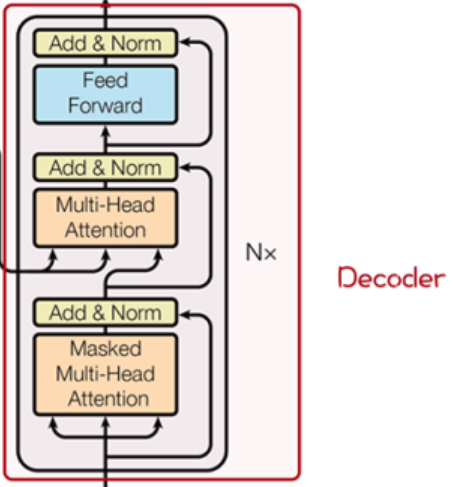
我们将原始的masked multi-head attention替换为multi-head attention 
+ 原因：因为我们的任务不属于生成任务，所以文本在训练过程中它的全局细信息对于模型来说是已知的，不需要mask操作来进行遮挡

**transform结构**

In [ ]:
class Transformer(nn.Cell):
    def __init__(self,image_size: int = 224,
                 input_channels: int = 3,
                 patch_size: int = 16,
                 embed_dim: int = 768,
                 num_layers: int = 12,
                 num_heads: int = 12,
                 mlp_dim: int = 3072,
                 n_class: int = 2,
                 vocab_size:int=10310,
                 activation: nn.Cell = nn.GELU,
                 norm: nn.Cell = nn.LayerNorm,
                 pool :str = 'relu',#Vit的最后层输出改为一层激活层，保持patch的原始形状
                 keep_prob: float = 1.0):
        super(Transformer, self).__init__()
        self.encoder = ViT(image_size=image_size,input_channels=input_channels,patch_size=patch_size,
                           embed_dim=embed_dim,num_layers=num_layers,num_heads=num_heads,mlp_dim=mlp_dim,pool=pool)#vit模块进行图像编码
        self.decoder = mytransformerDecoder(dim=embed_dim,
                 num_layers=num_layers,
                 num_heads=num_heads,
                 mlp_dim=mlp_dim,
                vocab_size=vocab_size,
                 attention_keep_prob= 1.0,
                 drop_path_keep_prob= 1.0,
                 activation= activation,
                 norm=norm)#transformer的decoder部分用来编码文本
        #print(type(activation))
        self.dropout = nn.Dropout(keep_prob)
        self.mean = P.ReduceMean()
        #self.dense = nn.Dense(embed_dim*((image_size**2)//(patch_size**2)), 1, has_bias=True)
        self.dense = nn.Dense(embed_dim,1,has_bias=True)
        self.sigmoid = nn.Sigmoid()
        self.reshape = P.Reshape()

    def construct(self, encoder_x,decoder_x,seq_length):
        encoder_out = self.encoder(encoder_x)
        decoder_out = self.decoder(encoder_out,decoder_x,seq_length)#将图像特征通过transformer的decoder部分融合图像和文本特征
        b, n, dim = decoder_out.shape

        # if self.train:
        #     x = self.dropout(encoder_out)
        decoder_out = self.mean(decoder_out,(1,))#平均池化层进行特征降维
        print('encoder_out:', decoder_out.shape)
        #decoder_out = self.reshape(decoder_out, (b, n * dim))
        x = self.dense(decoder_out)
        x = self.sigmoid(x)
        # if self.train:
        #     x = self.dropout(decoder_out)
        return x

**attention结构**

与自注意力结构不同，该模型的QKV不是来自于同一输入，而是分别来自vit-encoder和decoder部分。

In [ ]:
class myAttention(nn.Cell):
    def __init__(self,
                 dim: int,
                 num_heads: int = 8,
                 keep_prob: float = 1.0,
                 attention_keep_prob: float = 1.0):
        super(myAttention, self).__init__()
        Validator.check_equal_int(dim % num_heads, 0, 'dim should be divisible by num_heads.')
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = Tensor(head_dim ** -0.5)
        self.q = nn.Dense(dim,dim) #与自注意力层不同，decoder的第二层注意力的QKV的Q来自于vit-encoder部分需要单独处理
        self.kv = nn.Dense(dim, dim * 2)
        self.qkv = P.Concat(axis=2)
        self.attn_drop = nn.Dropout(attention_keep_prob)
        self.out = nn.Dense(dim, dim)
        self.out_drop = nn.Dropout(keep_prob)

        self.mul = P.Mul()
        self.reshape = P.Reshape()
        self.transpose = P.Transpose()
        self.unstack = P.Unstack(axis=0)
        self.attn_matmul_v = P.BatchMatMul()
        self.q_matmul_k = P.BatchMatMul(transpose_b=True)
        self.softmax = nn.Softmax(axis=-1)

    def construct(self, x1,x2):
        """Attention construct."""
        b_q,n_q,c_q = x1.shape
        b, n, c = x2.shape
        q = self.q(x1)
        kv = self.kv(x2)
        print(q.shape,kv.shape)
        #qkv = self.qkv((q,kv))
        q = self.reshape(q, (b_q, n_q, self.num_heads, c_q // self.num_heads))
        q = self.transpose(q, (0,2,1,3)) #注意相对于KV,KV在进行unstack操作后会缩减一维，Q的维度要和K，V保持一致
        kv = self.reshape(kv, (b, n, 2, self.num_heads, c // self.num_heads))
        kv = self.transpose(kv, (2, 0, 3, 1, 4))
        k, v = self.unstack(kv)

        #print(q.shape,k.shape,v.shape)
        attn = self.q_matmul_k(q, k)
        attn = self.mul(attn, self.scale)
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        out = self.attn_matmul_v(attn, v)
        out = self.transpose(out, (0, 2, 1, 3))
        out = self.reshape(out, (b_q, n_q, c_q))
        out = self.out(out)
        out = self.out_drop(out)
        #print(out.shape)
        return out

**TransformerDecoderLayer结构**

主要实现每层的计算过程，由于拥有多个输入，无法直接进行模型简单的堆叠计算。

In [ ]:
class myTransformerDecoderLayer(nn.Cell):
    def __init__(self,
                 dim: int,
                 num_heads: int,
                 mlp_dim: int,
                 keep_prob: float = 1.,
                 attention_keep_prob: float = 1.0,

                 activation: nn.Cell = nn.GELU,
                 norm: nn.Cell = nn.LayerNorm):
        super(myTransformerDecoderLayer, self).__init__()

        self.normalization1 = norm((dim,))
        self.normalization2 = norm((dim,))
        self.normalization3 = norm((dim,))
        self.attention = Attention(dim=dim,
                              num_heads=num_heads,
                              keep_prob=keep_prob,
                              attention_keep_prob=attention_keep_prob)
        self.mul_attention = Attention2(dim=dim,
                                   num_heads=num_heads,
                                   keep_prob=keep_prob,
                                   attention_keep_prob=attention_keep_prob)

        self.feedforward = FeedForward(in_features=dim,
                                  hidden_features=mlp_dim,
                                  activation=activation,
                                  keep_prob=keep_prob)

    def construct(self, encode_input,decode_input): #与vit-decoder部分不同，decoder-layer无法通过Sequential进行连接，因为有多个输入，需要将每层的计算过程明确写出来
        """Transformer construct."""

        encode_attention = self.attention(encode_input)

        encode_x = self.normalization1(encode_attention)+ encode_input#残差结构

        encode_decode_attention = self.mul_attention(encode_x,decode_input)
        enc_dec_normal = self.normalization2(encode_decode_attention) + encode_x#残差结构

        fc = self.feedforward(enc_dec_normal)

        return self.normalization3(fc) + enc_dec_normal#残差结构

**LSTM结构**

In [ ]:
class myLSTM(nn.Cell):
    def __init__(self,vocab_size,hidden_dim,embedding_dim,padding_idx=0):
        super(myLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, bidirectional=True, batch_first=True) #双向LSTM

    def construct(self, inputs, seq_length, tags=None):
        embeds = self.embedding(inputs)
        outputs, _ = self.lstm(embeds, seq_length=seq_length)

        return outputs

**TransformerDecoder结构**

用来将LSTM模型和transformerdecoder-layer模型整合到一起。

In [ ]:
class mytransformerDecoder(nn.Cell):

    def __init__(self, dim: int,
                 num_layers: int,
                 num_heads: int,
                 mlp_dim: int,
                 vocab_size: int,
                 keep_prob: float = 1.,
                 attention_keep_prob: float = 1.0,
                 drop_path_keep_prob: float = 1.0,

                 activation: nn.Cell = nn.GELU,
                 norm: nn.Cell = nn.LayerNorm):

        super(mytransformerDecoder, self).__init__()

        drop_path_rate = 1.0 - drop_path_keep_prob
        dpr = [i.item() for i in np.linspace(0, drop_path_rate, num_layers)]
        mlp_seeds = [np.random.randint(1024) for _ in range(num_layers)]

        layers = []
        for i in range(num_layers):


            if drop_path_rate > 0:
                layers.append(
                        nn.SequentialCell([myTransformerDecoderLayer(dim = dim,num_heads=num_heads,mlp_dim=mlp_dim,
                                                                     keep_prob=keep_prob,attention_keep_prob=attention_keep_prob,
                                                                     activation=activation,
                                                                     norm =norm),
                                           DropPath(dpr[i], mlp_seeds[i])
                                           ]))
            else:
                layers.append(
                    myTransformerDecoderLayer( dim = dim,num_heads=num_heads, mlp_dim=mlp_dim,
                                                   keep_prob=keep_prob, attention_keep_prob=attention_keep_prob,
                                                   activation=activation,
                                                   norm=norm)

                )
        self.layers = nn.SequentialCell(layers)
    
        self.lstm = myLSTM(vocab_size=vocab_size,hidden_dim=dim,embedding_dim=100)


    def construct(self, encode_input,decode_input,seq_length):
        decode_input = self.lstm(decode_input,seq_length)#对输入的文本进行lstm编码
        for layer in self.layers:
            decode_out = layer(encode_input,decode_input)#与vit-decoder不同，无法直接进行self.layers(x)进行计算，需要每层进行计算
            decode_input = decode_out

        return decode_out

**ViT模型结构**

ViT模型代码主要来自于mindspore框架，这里根据项目任务对其进行了一些简单的修改，主要将vit模型的最后一层换为激活函数层，目的是为了保持编码后的patch图像特征形状编码，在decoder部分与文本特征进行融合。

In [ ]:
class ViT(nn.Cell):
    def __init__(self,
                 image_size: int = 224,
                 input_channels: int = 3,
                 patch_size: int = 16,
                 embed_dim: int = 768,
                 num_layers: int = 12,
                 num_heads: int = 12,
                 mlp_dim: int = 3072,
                 keep_prob: float = 1.0,
                 attention_keep_prob: float = 1.0,
                 drop_path_keep_prob: float = 1.0,
                 activation: nn.Cell = nn.GELU,
                 norm: nn.Cell = nn.LayerNorm,
                 pool: str = 'mean') -> None:
        super(ViT, self).__init__()

        Validator.check_string(pool, ["cls", "mean","relu"], "pool type")#对原始的vit进行了一些修改，保持最后输出的形状，只添加一层激活函数

        self.patch_embedding = PatchEmbedding(image_size=image_size,
                                              patch_size=patch_size,
                                              embed_dim=embed_dim,
                                              input_channels=input_channels)
        num_patches = self.patch_embedding.num_patches

        if pool == "cls":
            self.cls_token = init(init_type=Normal(sigma=1.0),
                                  shape=(1, 1, embed_dim),
                                  dtype=ms.float32,
                                  name='cls',
                                  requires_grad=True)
            self.pos_embedding = init(init_type=Normal(sigma=1.0),
                                      shape=(1, num_patches + 1, embed_dim),
                                      dtype=ms.float32,
                                      name='pos_embedding',
                                      requires_grad=True)
            self.concat = P.Concat(axis=1)
        elif pool == 'mean':
            self.pos_embedding = init(init_type=Normal(sigma=1.0),
                                      shape=(1, num_patches, embed_dim),
                                      dtype=ms.float32,
                                      name='pos_embedding',
                                      requires_grad=True)
            self.mean = P.ReduceMean(keep_dims=False)

        else:
            self.pos_embedding = init(init_type=Normal(sigma=1.0),
                                      shape=(1, num_patches, embed_dim),
                                      dtype=ms.float32,
                                      name='pos_embedding',
                                      requires_grad=True)
            self.relu = nn.ReLU()

        self.pool = pool
        self.pos_dropout = nn.Dropout(keep_prob)
        self.norm = norm((embed_dim,))
        self.tile = P.Tile()
        self.transformer = TransformerEncoder(dim=embed_dim,
                                              num_layers=num_layers,
                                              num_heads=num_heads,
                                              mlp_dim=mlp_dim,
                                              keep_prob=keep_prob,
                                              attention_keep_prob=attention_keep_prob,
                                              drop_path_keep_prob=drop_path_keep_prob,
                                              activation=activation,
                                              norm=norm)

    def construct(self, x):
        """ViT construct."""
        x = self.patch_embedding(x)

        if self.pool == "cls":
            cls_tokens = self.tile(self.cls_token, (x.shape[0], 1, 1))
            x = self.concat((cls_tokens, x))
            x += self.pos_embedding
        else:
            x += self.pos_embedding
        x = self.pos_dropout(x)
        x = self.transformer(x)
        x = self.norm(x)

        if self.pool == "cls":
            x = x[:, 0]
        elif self.pool == "mean":
            x = self.mean(x, (1,))  # (1,) or (1,2)
            #x = self.relu(x)
        else:#保持形状不变 （批次，pacth,dim）
            x = self.relu(x)
        return x

## 四、模型训练、验证与预测

### 1.模型训练

#### （1）自定义训练过程

In [ ]:
class WithLossCellTrans(nn.Cell):
    """链接loss_fn和网络"""
    def __init__(self,net,loss_fn):
        super(WithLossCellTrans, self).__init__(auto_prefix=True)
        self.net = net
        self.loss_fn = loss_fn

    def construct(self,image,sentence,seq_length,label):
        out = self.net(image,sentence,seq_length)
        loss = self.loss_fn(out,label)
        return loss.mean()


class CustomTrainOneStepCell(nn.Cell):
    """自定义训练网络"""

    def __init__(self, network, optimizer):
        """入参有两个：训练网络，优化器"""
        super(CustomTrainOneStepCell, self).__init__(auto_prefix=False)
        self.network = network                           # 定义前向网络
        self.network.set_grad()                          # 构建反向网络
        self.optimizer = optimizer                       # 定义优化器
        self.weights = self.optimizer.parameters         # 待更新参数
        self.grad = ops.GradOperation(get_by_list=True)  # 反向传播获取梯度

    def construct(self, image,sentence,seq_length,label):
        loss = self.network(image,sentence,seq_length,label)                            # 计算当前输入的损失函数值
        grads = self.grad(self.network, self.weights)(image,sentence,seq_length,label)  # 进行反向传播，计算梯度
        self.optimizer(grads)                                   # 使用优化器更新权重参数
        return loss

#### (2)定义优化器和损失函数，将其与网络进行连接

In [ ]:
import mindspore.nn as nn
from mindspore.train import Model
from mindvision.engine.loss import CrossEntropySmooth
from transformer import Transformer
from mindvision.engine.callback import LossMonitor
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig
from dataload import MyDataset
import mindspore.dataset as ds
from mindspore import context
import mindspore.ops as ops
import mindspore as ms

#定义网络
network = Transformer(image_size=224,input_channels=3,patch_size=16,embed_dim=32,num_heads=8,num_layers=3,mlp_dim=128,pool='relu')

# 定义损失函数
net_loss = nn.BCELoss(reduction='mean')

# 定义优化器函数
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)

# 连接前向网络与损失函数
net_with_loss = WithLossCellTrans(network, net_loss)
opt = nn.Momentum(network.trainable_params(), learning_rate=0.005, momentum=0.9)

# 定义训练网络，封装网络和优化器
train_net = CustomTrainOneStepCell(net_with_loss, opt)


#### （3）获取数据集开始训练

In [ ]:
context.set_context(mode=context.PYNATIVE_MODE)#设为动态图模型
dataset_generator = MyDataset()
train_dataset = ds.GeneratorDataset(dataset_generator, ["image","sentence","length" ,"label"], shuffle=False).batch(100)
step = 0
epochs = 10
steps = train_dataset.get_dataset_size()



for epoch in range(epochs):
    for d in train_dataset.create_dict_iterator():
        print(d['image'].shape,d['sentence'].shape,d["length"].shape,d['label'].shape)
        result = train_net(d["image"],d["sentence"],d["length"], d["label"])
        print(f"Epoch: [{epoch} / {epochs}], "
              f"step: [{step} / {steps}], "
              f"loss: {result}")
        step = step + 1

ms.save_checkpoint(network,'model_path/transformer.ckpt')

输出结果：

#### （4）保存模型

In [ ]:
ms.save_checkpoint(network,'model_path/transformer.ckpt')

### 2.模型验证

#### （1）自定义验证网络

验证时用精确率（acc）来表示模型的性能，没有用到loss_fn,所以不用编写相应的loss连接网络。

In [ ]:
class CustomWithEvalCell(nn.Cell):

    def __init__(self, network):
        super(CustomWithEvalCell, self).__init__(auto_prefix=False)
        self.network = network

    def construct(self, data1, data2, data3,label):

        outputs = self.network(data1,data2,data3)
        x = (outputs>0.5).astype(np.float32)
        acc = (x==label).astype(np.float32)
        mean = P.ReduceMean()
        acc = mean(acc)
        return acc


#### （2）定义验证网络，载入之前的模型文件，并与验证网络绑定。

In [ ]:
network = Transformer(image_size=224,input_channels=3,patch_size=16,embed_dim=32,num_heads=8,num_layers=3,mlp_dim=128,pool='relu')
param_dict = load_checkpoint("model_path/transformer.ckpt")#加载预训练模型

load_param_into_net(network, param_dict)
custom_eval_net = CustomWithEvalCell(network)
custom_eval_net.set_train(False)#关闭训练模式

#### （3）开始验证过程

In [ ]:
import mindspore.nn as nn
from transformer import Transformer
from dataload import MyDataset
import mindspore.dataset as ds
from mindspore import context
import mindspore.ops as ops
import mindspore as ms
import numpy as np
from mindspore.ops import operations as P

from mindspore import load_checkpoint, load_param_into_net

dataset_generator = MyDataset('val')
train_dataset = ds.GeneratorDataset(dataset_generator, ["image","sentence", "length","label"], shuffle=False).batch(64)

context.set_context(mode=context.PYNATIVE_MODE)
steps = train_dataset.get_dataset_size()
step=0

acc_avg=0
for d in train_dataset.create_dict_iterator():
    print(d['image'].shape,d['sentence'].shape,d["length"].shape,d['label'].shape)
    result = train_net(d["image"],d["sentence"],d["length"], d["label"])
    acc_avg = result+acc_avg
    print(f"step: [{step} / {steps}], "
          f"ACC: {result}")
    step = step + 1

print(f"acc_avg:{acc_avg/step}")

输出结果：

### 3.模型预测

#### （1）自定义预测网络

In [ ]:
class CustomWithTestCell(nn.Cell):

    def __init__(self, network):
        super(CustomWithTestCell, self).__init__(auto_prefix=False)
        self.network = network

    def construct(self, data1, data2,data3):

        outputs = self.network(data1,data2,data3)
        predict = (outputs>0.5).astype(np.float32)

        return predict

#### （2）加载预训练模型，实例化网络，与预测网络进行绑定

In [ ]:
network =Transformer(image_size=224,input_channels=3,patch_size=16,embed_dim=64,num_heads=8,num_layers=5,mlp_dim=128,pool='relu')

param_dict = load_checkpoint("model_path/transformer.ckpt")

load_param_into_net(network, param_dict)
custom_test_net = CustomWithTestCell(network)
custom_test_net.set_train(False)

#### （3）读取预测数据

In [ ]:
idx = 0

def prepare_sequence(seqs, word_to_idx):
    seq_outputs, label_outputs, seq_length = [], [], []
    #print(seqs)
    max_len = max([len(i) for i in seqs])
    print(max_len)

    for seq in seqs:
        #print(seq)
        seq_length.append(len(seq))
        idxs = [word_to_idx[w] for w in seq]
        idxs.extend([word_to_idx['<pad>'] for i in range(max_len - len(seq))])
        #print('idsx',len(idxs),'seq_length',seq_length)
        seq_outputs.append(idxs)


    return np.array(seq_outputs, dtype=np.int64),np.array(seq_length, dtype=np.int64)

sen_data=[]
img_list=[]
label=[]

idx=1
with open('dataset/test/test.txt') as f:
    for line in f:
        line = line.strip()
        parts = line.split('\t')
        sen_data.append(parts[0].split(' '))
        img_list.append(parts[1])
        label.append(int(parts[2]))
        if idx ==10:
            break
        idx+=1

img = []

idx=1
for img_path in img_list:
    image = Image.open(img_path)
    image= image.resize((224,224))
    x = np.copy(image)
    data = ((x - np.min(x)) / (np.max(x) - np.min(x))).astype(np.float32)
    #print(data.shape)
    data = data.swapaxes(0,2)
    data = data.swapaxes(1, 2)
    #print(data.shape)
    img.append(data)
    if idx == 10:
        break
    idx += 1

with open('dataset/word2id.json') as f:
    word2id = json.load(f)

sen,length = prepare_sequence(sen_data,word2id)

image = ms.Tensor(np.array(img,dtype=np.float32))
sentence = ms.Tensor(sen)
length = ms.Tensor(length)
label = ms.Tensor(np.array(label))

#### （4）开始预测

In [ ]:
import mindspore.nn as nn
from transformer import Transformer
from dataload import MyDataset
import mindspore.dataset as ds
from mindspore import context
import mindspore.ops as ops
import mindspore as ms
import numpy as np
from mindspore.ops import operations as P
from PIL import Image
from mindspore import load_checkpoint, load_param_into_net
import json


context.set_context(mode=context.PYNATIVE_MODE)
predict = custom_test_net(image,sentence,length).reshape(-1)

for i in range(len(predict)):
    print(f"文本：{' '.join(sen_data[i])},真实值：{label[i]},预测值:{predict[i]}")

输出结果: